# Agent-based credit risk modeling

Summer School Bayonne July 2025<br>
Author:      Dr. Mario Gellrich<br><br>
Last update: 2025-07-01

<p>The term 'credit risk' refers to the risk that a lender may not receive the owed principal and interest. The principal is the amount a consumer borrowed and have to pay back. Interest is what the lender charges for lending the money. The credit risk of a borrower can be measured by the five Cs (see: <a>https://www.openriskmanual.org/wiki/Five_Cs_Of_Credit_Analysis</a>): capacity, capital, character, colletaral, conditions. Based on this information a credit score can be calculated for every consumer. A credit score is one indicator that lenders use to asses how likely it is that a borrower is to default. To compensate for the credit risk, consumers with lower credit scores are usually charged higher interest rates on loans than consumers with higher credit scores.</p>

<p>The agent-based model (ABM) provided in this Jupyter notebook is used to explore the role of different parameters like the number of agents and loan term on the credit risk. It contains a Lender class, a Borrower class and a CreditModel class. The model contains different time steps corresponding to the number of month in which the loan must be repayed (the loan term). The model also contains different borrower agents. Each borrower has a credit score ranging from 50 to 100. The interest rate depends on the credit risk score. If the credit risk score is high, the interest rate is low and vice versa.</p>
    
<p>At the beginning, each borrower asks for a random amount of money (the principle) between 50,000 and 500,000 USD. The model steps correspond to the number of months in which the loan must be repayed. At each model step, the borrower must repay the monthly loan. To make the simulation more realistic, the behavior of each borrower with regard to the repayment of the loan is AI-induced. As in practise, the monthly payment remains the same throughout the loan term, but the allocation between principal and interest changes over time. At the beginning, a larger portion of the payment goes towards interest, while towards the end, a larger portion goes towards the principal. Sometimes a borrower cannot repay the monthly loan. If this happens, the borrower must repay the monthly rate owed in the next model step. If a borrower cannot repay the loan for three consecutive months, this borrower is removed from the model, and the remaining loan is considered as defaulted.</p>

## Model description

## Libraries and settings

In [1]:
# Libraries
import os
import re
import json
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from openai import OpenAI

from mesa import Agent, Model
from mesa.time import RandomActivation

# Set random seed
random.seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# OpenAI API key
credentials = json.loads(Path('../credentials.json').read_text())['openai']
api_key = credentials.get('api_key')

# Create a client instance with the key
client = OpenAI(api_key=api_key)

# Show current working directory
print(os.getcwd())

/workspaces/summerschool/Agent_Based_Credit_Risk_Modeling


## Example loan calculation

See: https://www.calculator.net/loan-calculator.html

In [2]:
# Input
# p = loan amount (principle)
# r = monthly interest rate
# y = number of years
# n = total number of months

p = 100000
r = 0.05 / 12
y = 30
n = y*12

# Monthly loan
m = p * r * (1 + r)**n / ((1 + r)**n - 1)

# Summary of results
print(f"Principle: {p:.0f} USD")
print(f"Loan term: {y} years ({y*12} months)")
print(f"Interest rate: {r*12*100:.2f} %")
print(f"Monthly loan: {m:.2f} USD")
print(f"Annually loan: {m*12:.2f} USD")
print(f"Total interest over {y} years: {m*n - p:.2f} USD")
print(f"Principle plus interest over {y} years: {m*n:.2f} USD")


Principle: 100000 USD
Loan term: 30 years (360 months)
Interest rate: 5.00 %
Monthly loan: 536.82 USD
Annually loan: 6441.86 USD
Total interest over 30 years: 93255.78 USD
Principle plus interest over 30 years: 193255.78 USD


## Let gpt-3.5-turbo create a function to calculate the monthly loan

In [3]:
# Function to generate Python code based on a description using OpenAI's GPT-3.5-turbo
def generate_function_code(description):
    prompt = f"Write a Python function that does the following: {description}"

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    full_text = response.choices[0].message.content.strip()

    # Extract code block from Markdown-style fenced code blocks
    match = re.search(r"```python(.*?)```", full_text, re.DOTALL)
    if match:
        code_only = match.group(1).strip()
    else:
        # Fallback: try to keep only indented lines or plausible Python code
        lines = full_text.splitlines()
        code_only = "\n".join(line for line in lines if line.strip().startswith(
            "def") or line.strip().startswith(" ") or line.strip().startswith("#"))

    return code_only


# Example usage
description = """Calculate the monthly loan payment for a given loan amount, 
                 interest rate, and loan term in years. Test the function with
                 a loan amount of $100,000, an interest rate of 5%, and a loan 
                 term of 30 years."""

function_code = generate_function_code(description)
print("Generated function code:")
print(function_code)

Generated function code:
def calculate_monthly_payment(loan_amount, interest_rate, loan_term):
    monthly_interest_rate = interest_rate / 100 / 12
    total_payments = loan_term * 12
    monthly_payment = (loan_amount * monthly_interest_rate) / (1 - (1 + monthly_interest_rate) ** -total_payments)
    return monthly_payment

# Test the function with a loan amount of $100,000, an interest rate of 5%, and a loan term of 30 years
loan_amount = 100000
interest_rate = 5
loan_term = 30
monthly_payment = calculate_monthly_payment(loan_amount, interest_rate, loan_term)

print(f'The monthly loan payment for a $100,000 loan at 5% interest rate for 30 years is: ${monthly_payment:.2f}')


## Basic agent-based credit risk model

### Lender class

In [4]:
class Lender_(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    # Calculate interest rate depending on the borrowers credit score
    def calculate_interest_rate(self, borrower):
        interest_rate = 0.04 + ((100 - borrower.credit_score) * 0.0004)
        
        return interest_rate

### Borrower class

In [5]:
class Borrower_(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.credit_score = random.randint(50, 100)
        self.loan_amount = 100
        self.principle = self.loan_amount
    
    # Display balance
    def display_balance(self):
        print(f"Borrower {self.unique_id + 1}: Balance at step 0: {self.loan_amount:.2f}.- USD")

    # Loan payments per step (in this example, only the interest is payed)
    def step(self):
        repayment_amount = self.principle * self.interest_rate
        self.loan_amount -= repayment_amount

### CreditModel class

In [6]:
class CreditModel_(Model):
    def __init__(self, num_borrowers):
        self.num_agents = num_borrowers
        self.schedule = RandomActivation(self)
        self.step_number = 0

        for i in range(self.num_agents):
            a = Borrower_(i, self)
            self.schedule.add(a)

        # Instance of Lender class
        self.lender = Lender_(0, self)

        # Calculate and show interest rates of borrower agents
        self.interest_rate()

    def interest_rate(self):
        borrowers = self.schedule.agents
        for borrower in borrowers:
            borrower.interest_rate = self.lender.calculate_interest_rate(borrower)
            print(f"Interest rate of Borrower {borrower.unique_id + 1}: {borrower.interest_rate:.2%}")

    def step(self):
        self.step_number += 1
        self.schedule.step()


### Calling the Borrower, Lender and CreditModel classes

In [7]:
# Create a model with three agents
print("Interest rates of borrowers:")
model = CreditModel_(3)

# Print initial balance of agents
print("\nBalance of borrowers:")
for agent in model.schedule.agents:
    agent.display_balance()

# Run the model for five steps
for i in range(5):
    model.step()

    # Print the balance of each agent
    for agent in model.schedule.agents:
        print(f"Borrower {agent.unique_id + 1}: Balance at step {model.step_number}: {agent.loan_amount:.2f}.- USD")


Interest rates of borrowers:
Interest rate of Borrower 1: 4.40%
Interest rate of Borrower 2: 5.72%
Interest rate of Borrower 3: 5.96%

Balance of borrowers:
Borrower 1: Balance at step 0: 100.00.- USD
Borrower 2: Balance at step 0: 100.00.- USD
Borrower 3: Balance at step 0: 100.00.- USD
Borrower 1: Balance at step 1: 95.60.- USD
Borrower 2: Balance at step 1: 94.28.- USD
Borrower 3: Balance at step 1: 94.04.- USD
Borrower 1: Balance at step 2: 91.20.- USD
Borrower 2: Balance at step 2: 88.56.- USD
Borrower 3: Balance at step 2: 88.08.- USD
Borrower 1: Balance at step 3: 86.80.- USD
Borrower 2: Balance at step 3: 82.84.- USD
Borrower 3: Balance at step 3: 82.12.- USD
Borrower 1: Balance at step 4: 82.40.- USD
Borrower 2: Balance at step 4: 77.12.- USD
Borrower 3: Balance at step 4: 76.16.- USD
Borrower 1: Balance at step 5: 78.00.- USD
Borrower 2: Balance at step 5: 71.40.- USD
Borrower 3: Balance at step 5: 70.20.- USD


## Extended agent-based credit risk model

### Lender class

In [8]:
class Lender(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    # Calculate interest rate
    def calculate_interest_rate(self, credit_score):
        interest_rate = 0.04 + ((100 - credit_score) * 0.0004)
        
        return interest_rate

# Example call of the Lender class
l1 = Lender(1,1)
l1.calculate_interest_rate(85)

0.046

### Borrower class with AI-induced bevavior

In [9]:
class Borrower(Agent):
    PROFILES = ["impulsive", "disciplined", "unlucky"]

    def __init__(self, unique_id, model, num_months, prob, use_ai=False):
        super().__init__(unique_id, model)
        self.num_months = num_months
        self.use_ai = use_ai
        self.credit_score = random.randint(50, 100)
        self.profile = random.choice(self.PROFILES)

        lender = Lender(1, 1)
        self.interest_rate = lender.calculate_interest_rate(self.credit_score)
        self.monthly_rate = self.interest_rate / 12

        self.loan_amount = self.select_valid_loan_amount()
        loan_info = self.calculate_loan_amount()
        self.monthly_loan = loan_info[0]
        self.balance = loan_info[1]

        self.payed_off = False
        self.time_to_repay = self.num_months
        self.defaulted = []
        self.removed = 0

        self.income = self.simulate_income()
        self.expenses = self.simulate_expenses()
        self.prob = self.probability_of_payment(prob)

    def select_valid_loan_amount(self, max_total_payment=500_000):
        n = self.num_months
        r = self.monthly_rate
        valid_loans = []
        for p in range(50_000, 500_000, 5000):
            numerator = p * r * (1 + r) ** n
            denominator = (1 + r) ** n - 1
            monthly = numerator / denominator
            total = monthly * n
            if total <= max_total_payment:
                valid_loans.append(p)
        if not valid_loans:
            raise ValueError("No valid loan amount under the total payment cap.")
        return random.choice(valid_loans)

    def calculate_loan_amount(self):
        p = self.loan_amount
        r = self.monthly_rate
        n = self.num_months
        numerator = p * r * (1 + r) ** n
        denominator = (1 + r) ** n - 1
        monthly_loan = numerator / denominator
        total_loan = monthly_loan * n
        return [monthly_loan, total_loan, self.interest_rate, r]

    def simulate_income(self):
        base = 2000 + (self.credit_score - 50) * 80
        return random.randint(int(base * 0.9), int(base * 1.2))

    def simulate_expenses(self):
        if self.profile == "disciplined":
            return random.randint(int(self.income * 0.3), int(self.income * 0.5))
        elif self.profile == "impulsive":
            return random.randint(int(self.income * 0.6), int(self.income * 0.9))
        elif self.profile == "unlucky":
            return random.randint(int(self.income * 0.4), int(self.income * 0.8)) + random.randint(100, 500)

    def probability_of_payment(self, p=0.10, length=20):
        result = [0] * int(p * length) + [1] * (length - int(p * length))
        random.shuffle(result)
        return result

    def generate_behavior_prompt(self):
        return f"""
            You are simulating a {self.profile} borrower deciding whether to pay their monthly loan installment.

            Borrower profile: {self.profile.capitalize()}
            Credit score: {self.credit_score}
            Monthly income: ${self.income:,.2f}
            Monthly expenses: ${self.expenses:,.2f}
            Monthly loan payment: ${self.monthly_loan:,.2f}
            Remaining balance: ${self.balance:,.2f}
            Missed payments: {sum(self.defaulted)}
            Months left to repay: {self.time_to_repay}

            Based on this information, should the borrower pay this month?

            Respond with only: pay or miss.
            """

    def decide_to_pay(self):
        if self.use_ai:
            try:
                response = client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[
                        {"role": "system", "content": "You simulate realistic financial decision-making by borrowers."},
                        {"role": "user", "content": self.generate_behavior_prompt()}
                    ],
                    temperature=0.7
                )
                content = response.choices[0].message.content.strip().lower()
                return "pay" in content
            except Exception as e:
                print(f"[OpenAI error] {e}")
                return random.choice(self.prob) == 1
        else:
            return random.choice(self.prob) == 1

    def step(self):
        payment = 1 if self.decide_to_pay() else 0

        if payment == 1:
            missed = sum(self.defaulted)
            multiplier = missed + 1
            self.monthly_loan = self.calculate_loan_amount()[0] * multiplier
            self.balance -= self.monthly_loan
            self.defaulted = []
            self.payed_off = True
            self.time_to_repay -= 1
        else:
            self.defaulted.append(1)
            if sum(self.defaulted) < 3:
                self.payed_off = False
                self.time_to_repay -= 1
            else:
                self.model.remove_agent(self)
                self.removed = 1

# Example usage
b1 = Borrower(unique_id=1, model=1, num_months=360, prob=0.10, use_ai=False)
b1.calculate_loan_amount()

[605.4491022215734, 217961.67679976643, 0.0412, 0.0034333333333333334]

### CreditModel class

In [10]:
class CreditModel(Model):

    def __init__(self, num_borrowers, num_months, prob, use_ai=False):
        self.num_borrowers = num_borrowers
        self.num_months = num_months
        self.schedule = RandomActivation(self)
        self.step_number = 0
        self.prob = prob
        self.use_ai = use_ai

        # Create agents with unique IDs and AI toggle
        for i in range(self.num_borrowers):
            borrower = Borrower(i, self, num_months, prob, use_ai=use_ai)
            self.schedule.add(borrower)

        # Create an empty DataFrame to store results
        self.results_df = pd.DataFrame(columns=[
            'Borrower', 'Step', 'Principle', 'Credit_Score',
            'Interest_Rate', 'Balance', 'Payed_Off'
        ])

        # Store the initial state
        for agent in self.schedule.agents:
            new_row = {
                'Borrower': agent.unique_id,
                'Step': self.step_number,
                'Principle': agent.loan_amount,
                'Credit_Score': agent.credit_score,
                'Interest_Rate': agent.calculate_loan_amount()[2],
                'Balance': round(agent.balance, 2),
                'Payed_Off': agent.payed_off
            }
            self.results_df = pd.concat([self.results_df,
                                         pd.DataFrame(new_row, index=[0])],
                                        ignore_index=True)

    def step(self):
        self.step_number += 1
        self.schedule.step()

        for agent in self.schedule.agents:
            new_row = {
                'Borrower': agent.unique_id,
                'Step': self.step_number,
                'Principle': agent.loan_amount,
                'Credit_Score': agent.credit_score,
                'Interest_Rate': agent.calculate_loan_amount()[2],
                'Balance': round(agent.balance, 2),
                'Payed_Off': agent.payed_off
            }
            self.results_df = pd.concat([self.results_df,
                                         pd.DataFrame(new_row, index=[0])],
                                        ignore_index=True)

    def remove_agent(self, agent):
        self.schedule.remove(agent)

# Example call of the CreditModel class
cm1 = CreditModel(num_borrowers = 2, num_months = 3, prob = 0.05, use_ai=False)
for i in range(3):
    cm1.step()
cm1.results_df


,Borrower,Step,Principle,Credit_Score,Interest_Rate,Balance,Payed_Off
0,0,0,50000,87,0.0452,50377.14,False
1,1,0,400000,74,0.0504,403364.69,False
2,0,1,50000,87,0.0452,33584.76,True
3,1,1,400000,74,0.0504,268909.80,True
4,0,2,50000,87,0.0452,16792.38,True
5,1,2,400000,74,0.0504,134454.90,True
6,0,3,50000,87,0.0452,0.00,True
7,1,3,400000,74,0.0504,-0.00,True


### Model parameter settings

In [11]:
# Model parameters
# num_borrowers:    Number of borrower agents in the model
# num_months:       Credit period (loan term) in months
# prob_defaulted:   Base probability that a borrower cannot repay the monthly loan (fallback)
# use_ai:           Whether to use OpenAI for borrower decision-making (True = AI-based, False = probability-based)

num_borrowers = 25
num_months = 12
prob_defaulted = 0.10
use_ai = False

### Model run

In [12]:
# Model
model = CreditModel(num_borrowers=num_borrowers, 
                    num_months=num_months, 
                    prob=prob_defaulted,
                    use_ai=use_ai)

# Run the model for multiple timesteps
for i in range(num_months):
    model.step()

### Analysis of model results

#### Data frame with model results per step

In [13]:
df = model.results_df
df

,Borrower,Step,Principle,Credit_Score,Interest_Rate,Balance,Payed_Off
0,0,0,290000,60,0.0560,298871.75,False
1,1,0,405000,65,0.0540,416943.76,False
2,2,0,385000,88,0.0448,394406.49,False
3,3,0,395000,98,0.0408,403783.82,False
4,4,0,350000,58,0.0568,360861.55,False
...,...,...,...,...,...,...,...
320,20,12,440000,98,0.0408,-0.00,True
321,21,12,260000,65,0.0540,-0.00,True
322,22,12,60000,74,0.0504,-0.00,True
323,23,12,65000,89,0.0444,-0.00,True


#### Line charts with model results per step

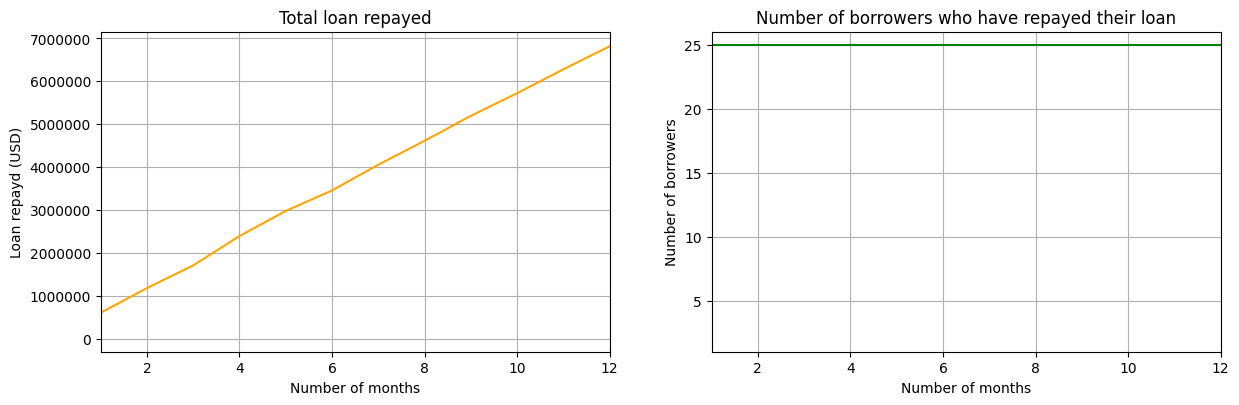

In [14]:
# Pivot tables with balances and borrowers
tab_balance = pd.pivot_table(df[['Step', 'Balance']],
                            index=['Step'],
                            values=['Balance'],
                            aggfunc=np.sum)

tab_borrowers = pd.pivot_table(df[['Step', 'Borrower']],
                                index=['Step'],
                                values=['Borrower'],
                                aggfunc='count')

# Line chart (balances)
tab_balance_sorted = tab_balance.sort_index(ascending=False)
fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=False)
ax[0].plot(tab_balance.index, tab_balance_sorted['Balance'], label="Repaid", color="orange")
ax[0].set_xlim(1, num_months)
ax[0].set_xlabel('Number of months')
ax[0].set_ylabel('Loan repayd (USD)')
ax[0].set_title('Total loan repayed')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].grid()

# Line chart (borrowers)
tab_borrowers_sorted = tab_borrowers.sort_index(ascending=False)
ax[1].plot(tab_borrowers.index, tab_borrowers['Borrower'], label="Repaid", color="green")
ax[1].set_xlim(1, num_months)
ax[1].set_ylim(1, num_borrowers + 1)
ax[1].set_xlabel('Number of months')
ax[1].set_ylabel('Number of borrowers')
ax[1].set_title('Number of borrowers who have repayed their loan')
ax[1].ticklabel_format(useOffset=False, style='plain')
ax[1].grid()

# Set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)

# Show plot
plt.show()

### Run multiple simulation models based on different model parameter settings

#### Function to run multiple simulation models and store the results

In [15]:
def simulation_models(num_borrowers, num_months, prob_defaulted, use_ai=use_ai):

    # Model
    model = CreditModel(num_borrowers=num_borrowers, 
                        num_months=num_months, 
                        prob=prob_defaulted,
                        use_ai=use_ai)

    # Run the model for multiple timesteps
    for i in range(num_months):
        model.step()

    # Output
    df = model.results_df

    # Loan
    loan_amount = df.loc[df['Step'] == 0]['Principle'].sum()
    loan_plus_interest = df.loc[df['Step'] == 0]['Balance'].sum()

    # Mean credit score
    mean_credit_score = df.loc[df['Step'] == 0]['Credit_Score'].mean()

    # Mean interest rate
    mean_interest_rate = df.loc[df['Step'] == 0]['Interest_Rate'].mean()

    # Mean loan amount
    mean_loan_amount = df.loc[df['Step'] == 0]['Principle'].mean()

    # Defaulted loan
    defaulted_list = []
    idx = list(set(df['Borrower']))

    for i in idx:
        defaulted_list.append(df.loc[(df['Borrower'] == i)]['Balance'].iloc[-1])

    defaulted_loan_abs = sum(defaulted_list)
    defaulted_loan_rel = sum(defaulted_list) / loan_plus_interest

    # Defaulted borrowers
    defaulted_borrowers = tab_borrowers['Borrower'].iloc[0] - tab_borrowers['Borrower'].iloc[-1]

    # Profit (for simplification, the costs of investments are ignored here)
    profit_abs = (loan_plus_interest - defaulted_loan_abs) - loan_amount
    profit_rel = (profit_abs / loan_amount)

    # Return on investment (ROI)
    roi = profit_rel / (num_months / 12)

    # Save results as data frame
    df_exp = pd.DataFrame({ 'Borrowers': num_borrowers,
                            'Months': num_months,
                            'Mean_Credit_Score': int(mean_credit_score),
                            'Mean_Interest_Rate': mean_interest_rate,
                            'Mean_Loan_Amount': int(mean_loan_amount),
                            'Total_Loan_Amount': int(loan_amount),
                            'Total_Loan_Amount_plus_Interest': int(loan_plus_interest),
                            'Borrowers_Defaulted': defaulted_borrowers,
                            'Defaulted_Loan': defaulted_loan_rel, 
                            'ROI': roi}, index=[0])

    return df_exp

#### Run multiple simulations

In [16]:
# Initialize df_sim as an empty data frame
df_sim = pd.DataFrame()

# List with the number of months for simulation
param_month = [num * 36 for num in range(1, 10 + 1)]
print("Number of months in the simulation:", param_month)

# Loop
for i in param_month:
    df_res = simulation_models(num_borrowers=25, 
                               num_months=i,
                               prob_defaulted=0.10)
    
    df_sim = pd.concat([df_sim, df_res.reindex(df_res.index)], axis=0)

# Result
df_sim

Number of months in the simulation: [36, 72, 108, 144, 180, 216, 252, 288, 324, 360]


,Borrowers,Months,Mean_Credit_Score,Mean_Interest_Rate,Mean_Loan_Amount,Total_Loan_Amount,Total_Loan_Amount_plus_Interest,Borrowers_Defaulted,Defaulted_Loan,ROI
0,25,36,67,0.053120,247800,6195000,6716088,0,0.003147,0.026901
0,25,72,72,0.051024,210200,5255000,6086348,0,0.004975,0.025407
0,25,108,76,0.049232,230000,5750000,7151328,0,0.030176,0.022909
0,25,144,72,0.050992,194200,4855000,6459231,0,0.070922,0.019673
0,25,180,69,0.052176,228600,5715000,8266514,0,0.178516,0.012550
0,25,216,73,0.050736,171000,4275000,6480475,0,0.097368,0.020461
0,25,252,80,0.047824,176600,4415000,6957933,0,0.040828,0.024363
0,25,288,75,0.049968,166000,4150000,7143458,0,0.081253,0.024227
0,25,324,72,0.050912,155000,3875000,7097048,0,0.194779,0.017584
0,25,360,77,0.048928,151600,3790000,7169697,0,0.045697,0.026843


#### Defaulted loan versus credit period in months

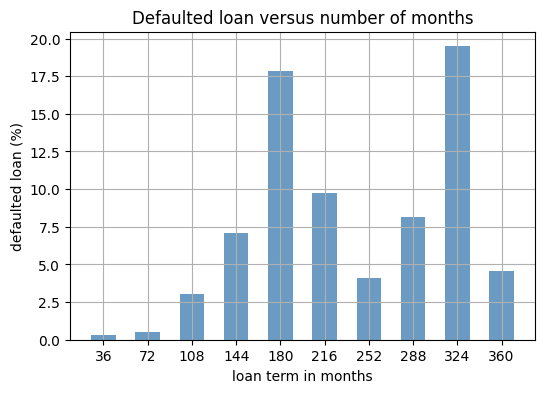

In [17]:
# Bar chart
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(df_sim['Months'],
       df_sim['Defaulted_Loan']*100, 
       align='center',
       color='steelblue', 
       alpha=0.8,
       width=20)
ax.set_title('Defaulted loan versus number of months')
ax.set_xlabel('loan term in months')
ax.set_ylabel('defaulted loan (%)')
ax.set_xticks(df_sim['Months'])
ax.set_xticklabels(df_sim['Months']) 
ax.grid()

# Show graph
plt.show()

#### ROI versus defaulted loan

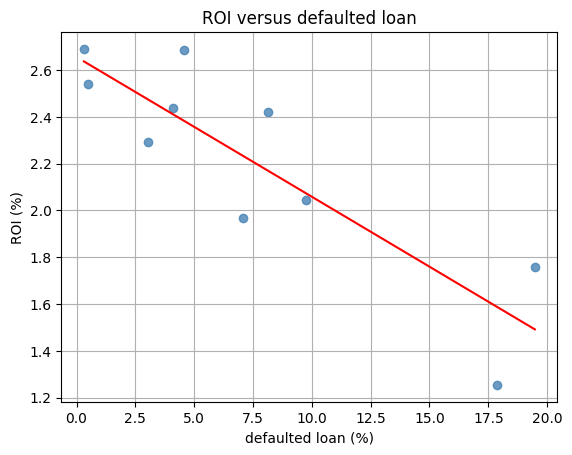

In [18]:
# Scatter plot
x = df_sim['Defaulted_Loan']*100
y = df_sim['ROI']*100

# Fit a function
fit = np.polyfit(x, y, 2)
p = np.poly1d(fit)

# Scatterplot
plt.scatter(x, y, color='steelblue', alpha=0.8)

# Create x values for the polynomial fit line
x_fit = np.linspace(x.min(), x.max(), 100)

# Create line showing the polynomial fit
plt.plot(x_fit, p(x_fit), 'r')

# Adding labels and title
plt.title('ROI versus defaulted loan')
plt.xlabel('defaulted loan (%)')
plt.ylabel('ROI (%)')
plt.grid()

# Displaying the scatter plot
plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [19]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.8.0-1027-azure
Datetime: 2025-07-04 13:14:27
Python Version: 3.11.12
-----------------------------------
